# House Prices: Advanced Regression Techniques, Part 1
## Load, explore, and clean the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from IPython.display import display
pd.options.display.precision = 4
mpl.rcParams['font.family'] = 'Lato'
mpl.rcParams['font.weight'] = 700
sns.set(font='Lato', font_scale=1)
sns.set()
np.random.seed(42)

https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data

Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.

## Load the Data

The data set is split across three tables:

- `listing_training`
- `zoning`
- `sale`

Load the data from these tables:
1. connect to the database using `psycopg2`
1. use a `psycopg2.extras.RealDictCursor` so that you get the columns names returned with your query
1. pull the data using a `SELECT` `JOIN` statement 
1. you should be able to join all tables using `id`
1. load the result into a `pandas.DataFrame`
1. use `id` as the index for your DataFrame

In [2]:
import psycopg2 as pg2
import psycopg2.extras as pgex

this_host='michaelgfrantz.com'
this_user='postgres'
this_password='dsism4'

conn = pg2.connect(host = this_host, 
                        user = this_user,
                        password = this_password)
curs = conn.cursor(cursor_factory=pgex.RealDictCursor)
#execute SQL query
query = """  select * 
            from listing_training l
            join zoning z on l.id = z.id
            join sale s on l.id = s.id;
"""
curs.execute(query)
results = curs.fetchall()
conn.close()
houseprice_df = pd.DataFrame(results)
houseprice_df.set_index('id',drop=True, inplace = True)
houseprice_df.shape

(1095, 80)

In [3]:
houseprice_df.head()

,alley,bedroomabvgr,bldgtype,bsmtcond,bsmtexposure,bsmtfinsf1,bsmtfinsf2,bsmtfintype1,bsmtfintype2,bsmtfullbath,...,secondflrsf,street,threessnporch,totalbsmtsf,totrmsabvgrd,utilities,wooddecksf,yearbuilt,yearremodadd,yrsold
id,,,,,,,,,,,,,,,,,,,,,
1,None,3,1Fam,TA,No,706,0,GLQ,Unf,1,...,854,Pave,0,856,8,AllPub,0,2003,2003,2008
4,None,3,1Fam,Gd,No,216,0,ALQ,Unf,1,...,756,Pave,0,756,7,AllPub,0,1915,1970,2006
5,None,4,1Fam,TA,Av,655,0,GLQ,Unf,1,...,1053,Pave,0,1145,9,AllPub,192,2000,2000,2008
7,None,3,1Fam,TA,Av,1369,0,GLQ,Unf,1,...,0,Pave,0,1686,7,AllPub,255,2004,2005,2007
8,None,3,1Fam,TA,Mn,859,32,ALQ,BLQ,1,...,983,Pave,0,1107,7,AllPub,235,1973,1973,2009


### What are the names of the columns?

In [4]:
houseprice_df.columns.values

array(['alley', 'bedroomabvgr', 'bldgtype', 'bsmtcond', 'bsmtexposure',
       'bsmtfinsf1', 'bsmtfinsf2', 'bsmtfintype1', 'bsmtfintype2',
       'bsmtfullbath', 'bsmthalfbath', 'bsmtqual', 'bsmtunfsf',
       'centralair', 'condition1', 'condition2', 'electrical',
       'enclosedporch', 'extercond', 'exterior1st', 'exterior2nd',
       'exterqual', 'fence', 'fireplacequ', 'fireplaces', 'firstflrsf',
       'foundation', 'fullbath', 'functional', 'garagearea', 'garagecars',
       'garagecond', 'garagefinish', 'garagequal', 'garagetype',
       'garageyrblt', 'grlivarea', 'halfbath', 'heating', 'heatingqc',
       'housestyle', 'kitchenabvgr', 'kitchenqual', 'landcontour',
       'landslope', 'lotarea', 'lotconfig', 'lotfrontage', 'lotshape',
       'lowqualfinsf', 'masvnrarea', 'masvnrtype', 'miscfeature',
       'miscval', 'mosold', 'mssubclass', 'mszoning', 'neighborhood',
       'openporchsf', 'overallcond', 'overallqual', 'paveddrive',
       'poolarea', 'poolqc', 'roofmatl', 'ro

### Find all the columns with over 500 null values

Use Python to find and drop these columns.

In [5]:
sum(houseprice_df['alley'].isnull())

1034

In [6]:
column_500null = []
houseprice_df_cleaning = houseprice_df.copy()
for col in houseprice_df.columns:
    if sum(houseprice_df[col].isnull()) > 500:
        houseprice_df_cleaning.drop(col,axis =1, inplace=True)
        column_500null.append(col)
column_500null


['alley', 'fence', 'fireplacequ', 'miscfeature', 'poolqc']

### How many columns of each data type are there?

In [7]:
data_type={}
for col in houseprice_df_cleaning.columns:
    key = houseprice_df_cleaning[col].dtype
    if key in data_type:
        data_type[key] += 1
    else: 
        data_type[key] = 1
data_type        

{dtype('int64'): 34, dtype('float64'): 3, dtype('O'): 38}

In [8]:
houseprice_df_cleaning.get_dtype_counts()

float64     3
int64      34
object     38
dtype: int64

### Create a Meta-Information DataFrame

1. call it `feature_info_df`
1. make an empty list called `feature_info`
1. for each column make a dictionary:  
   `{'feature':<column_name>,  
    'n_unique': <number_of_unique_elements>,  
    'datatype': <datatype_of_the_feature>}`
1. append the dictionary to the list `feature_info`
1. use the list of dictionaries to create a new dataframe

In [9]:
feature_info_df = houseprice_df_cleaning.copy()
feature_info = []
for col in feature_info_df.columns:
    info = { 
        'feature': col,
        'n_unique': len(set(feature_info_df[col])),
        'datatype': feature_info_df[col].dtype
    }
    feature_info.append(info)
feature_info_df = pd.DataFrame(feature_info)  
feature_info_df.head()

,datatype,feature,n_unique
0,int64,bedroomabvgr,7
1,object,bldgtype,5
2,object,bsmtcond,5
3,object,bsmtexposure,5
4,int64,bsmtfinsf1,525


### Display the meta information for all of the integers columns

In [10]:
feature_info_int_df = feature_info_df[feature_info_df['datatype']=='int64']
feature_info_int_df.head()

,datatype,feature,n_unique
0,int64,bedroomabvgr,7
4,int64,bsmtfinsf1,525
5,int64,bsmtfinsf2,113
8,int64,bsmtfullbath,4
9,int64,bsmthalfbath,3


### Use the meta-info dataframe to find all the integer features with 15 or less unique values

Make a list of these columns. We will change the type of these features to 'object' in our original dataframe.

In [11]:
object_list = []
for i in range(0,len(feature_info_int_df)):
   
    if feature_info_int_df['n_unique'].iloc[i] <15:
        object_list.append(feature_info_int_df['feature'].iloc[i])
object_list        

['bedroomabvgr',
 'bsmtfullbath',
 'bsmthalfbath',
 'fireplaces',
 'fullbath',
 'garagecars',
 'halfbath',
 'kitchenabvgr',
 'mosold',
 'overallcond',
 'overallqual',
 'poolarea',
 'totrmsabvgrd',
 'yrsold']

### Change the type of these features in your original dataframe to be `object` 
We will be treating these as categorical variables.

Change the datatype for each feature in your main dataframe.

In [12]:
for col in houseprice_df_cleaning.columns:
    if col in object_list:
        houseprice_df_cleaning[col] = houseprice_df_cleaning[col].astype('object')

### Update your meta-info dataframe

In [13]:
feature_info_df2 = houseprice_df_cleaning.copy()
feature_info_2 = []
for col in feature_info_df2.columns:
    info = { 
        'feature': col,
        'n_unique': len(set(feature_info_df2[col])),
        'datatype': feature_info_df2[col].dtype
    }
    feature_info_2.append(info)
feature_info_df2 = pd.DataFrame(feature_info_2)  
feature_info_df2.head()

,datatype,feature,n_unique
0,object,bedroomabvgr,7
1,object,bldgtype,5
2,object,bsmtcond,5
3,object,bsmtexposure,5
4,int64,bsmtfinsf1,525


### How many columns of each data type are there?

In [14]:
data_type={}
for col in houseprice_df_cleaning.columns:
    key = houseprice_df_cleaning[col].dtype
    if key in data_type:
        data_type[key] += 1
    else: 
        data_type[key] = 1
data_type     

{dtype('int64'): 20, dtype('float64'): 3, dtype('O'): 52}

### Change the remaining integer columns to float columns

In [15]:
for col in houseprice_df_cleaning.columns:
    if houseprice_df_cleaning[col].dtype =='int64':
        houseprice_df_cleaning[col]= houseprice_df_cleaning[col].astype('float64')

### How many columns of each data type are there?

In [16]:
data_type={}
for col in houseprice_df_cleaning.columns:
    key = houseprice_df_cleaning[col].dtype
    if key in data_type:
        data_type[key] += 1
    else: 
        data_type[key] = 1
data_type    

{dtype('float64'): 23, dtype('O'): 52}

### Create numerical and categorical dataframes

Display the shapes of these dataframes.

In [17]:
num_df = houseprice_df_cleaning.copy()
cat_df = houseprice_df_cleaning.copy()
for col in num_df.columns:
    if num_df[col].dtype == 'O':
        num_df=num_df.drop(col, axis = 1)
        
for col in cat_df.columns:
    if cat_df[col].dtype == 'float64':
        cat_df=cat_df.drop(col, axis = 1)    

### Find the features with nans in the numerical dataframe

In [18]:
num_null_list = []
for col in num_df.columns:
    if sum(num_df[col].isnull()) > 0:
        num_null_list.append(col)
        print(col,sum(num_df[col].isnull()))        

garageyrblt 63
lotfrontage 209
masvnrarea 6


### Replace the null rows for these features with either the mean or the median

In [19]:
for col in num_null_list:
    print('mean: ',num_df[col].mean())
    print('median: ', num_df[col].median())
    num_df[col] = num_df[col].where(num_df[col].isnull() == False,num_df[col].mean())
        

mean:  1979.40988372
median:  1982.0
mean:  70.3679458239
median:  70.0
mean:  97.9072543618
median:  0.0


### Use subplots to display distribution plots of all numerical features
Include the mean, median, and mode.

/opt/conda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


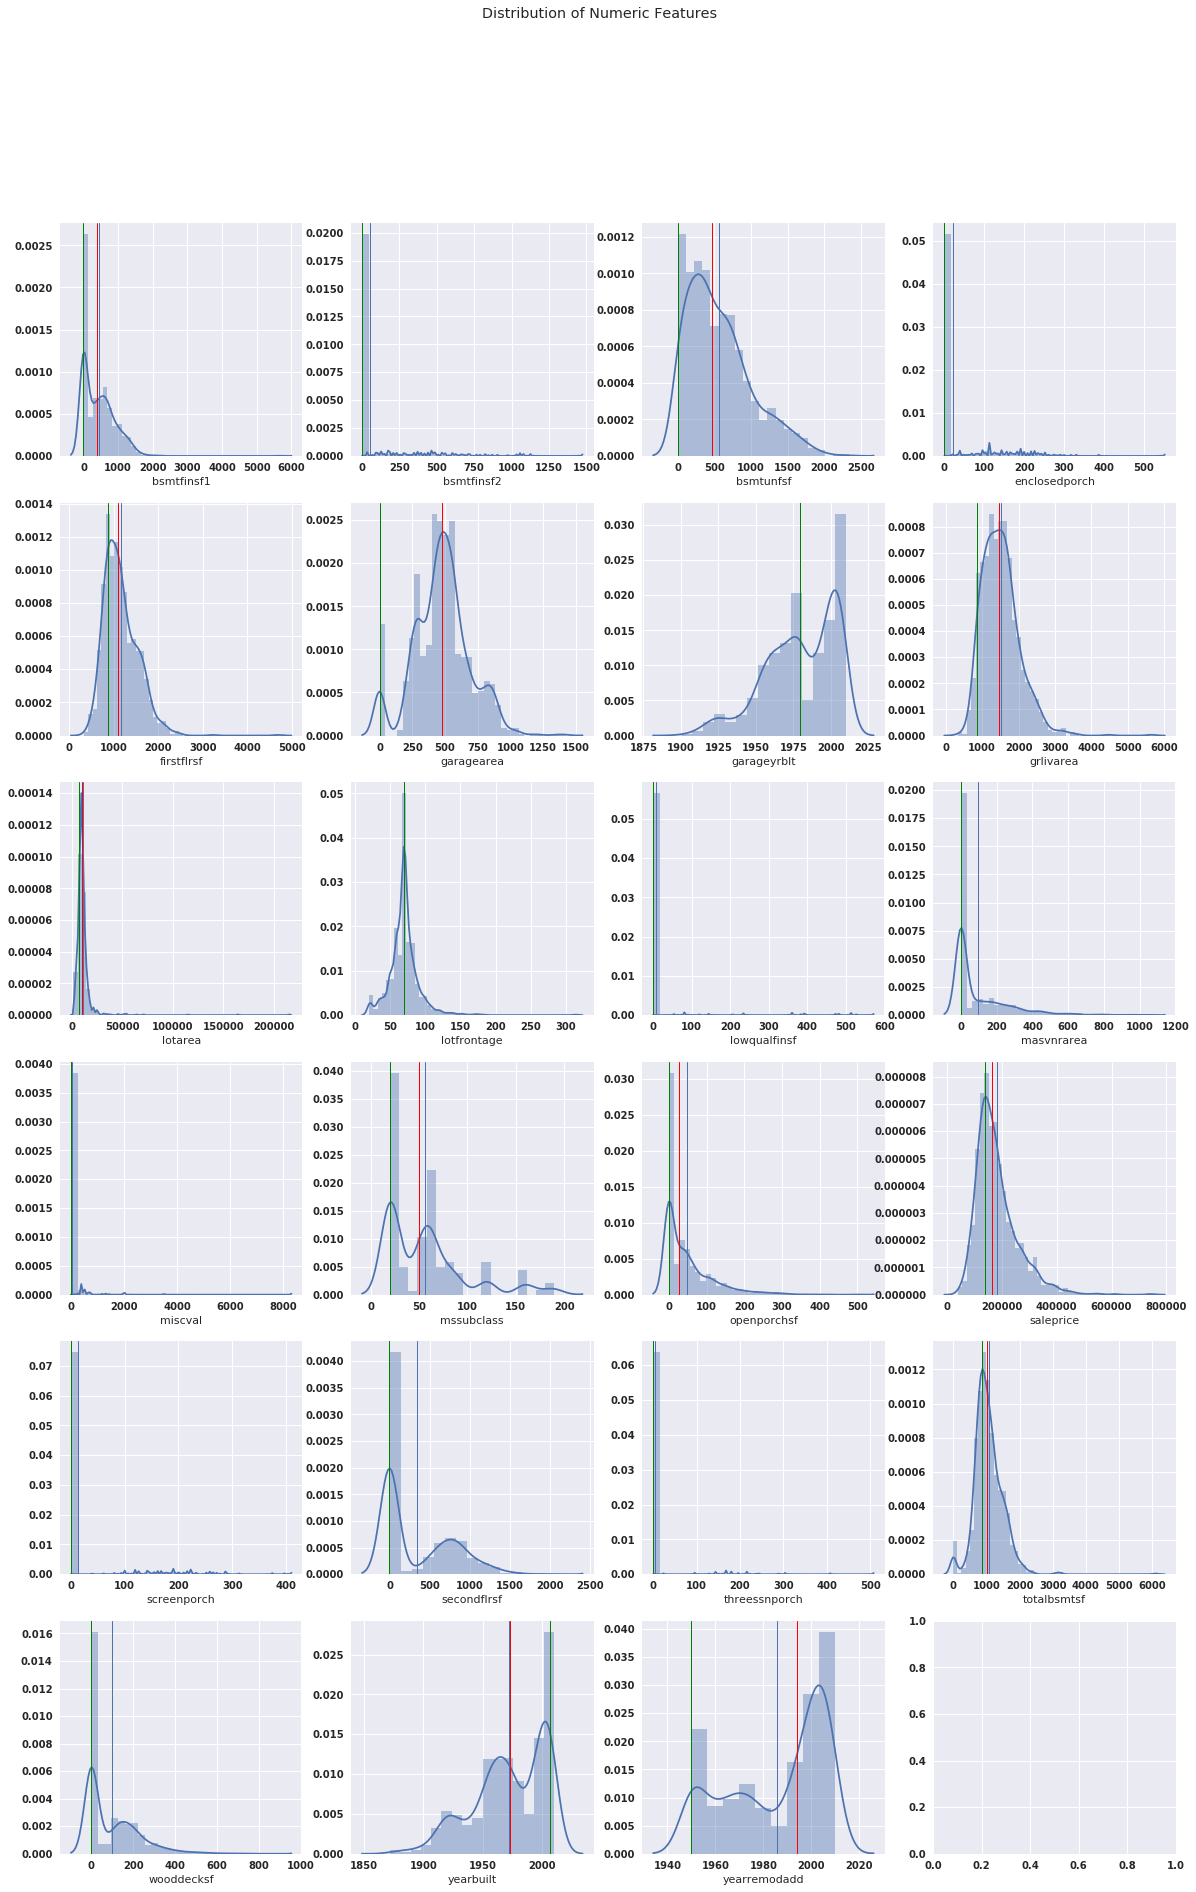

In [20]:
fig, axes = plt.subplots(6,4)
axes = axes.flatten()
fig.set_size_inches(20, 30)
fig.suptitle('Distribution of Numeric Features')
for i, col in enumerate(num_df.columns):
    feature = num_df[col]
    sns.distplot(feature, label=col, ax=axes[i])
    axes[i].axvline(feature.mean(),linewidth=1)
    axes[i].axvline(feature.median(),linewidth=1, color='r')
    axes[i].axvline(feature.mode().values[0],linewidth=1, color='g')
    plt.legend()

### Use `df.skew` to find the skew of the numerical features

In [21]:
from scipy.stats import skew, skewtest, normaltest
for col in num_df.columns:
    print(col,' P_Value: ', skewtest(num_df[col]).pvalue)

bsmtfinsf1  P_Value:  2.57543508741e-69
bsmtfinsf2  P_Value:  1.73947250751e-147
bsmtunfsf  P_Value:  1.01998983374e-26
enclosedporch  P_Value:  1.01934381638e-119
firstflrsf  P_Value:  3.88876434943e-49
garagearea  P_Value:  0.200482535605
garageyrblt  P_Value:  1.02698455204e-18
grlivarea  P_Value:  1.44162702808e-43
lotarea  P_Value:  0.0
lotfrontage  P_Value:  2.50303974344e-74
lowqualfinsf  P_Value:  1.08591981101e-254
masvnrarea  P_Value:  4.32157162188e-83
miscval  P_Value:  0.0
mssubclass  P_Value:  3.45637219594e-49
openporchsf  P_Value:  8.93702539415e-74
saleprice  P_Value:  2.54662471491e-59
screenporch  P_Value:  9.11189070488e-146
secondflrsf  P_Value:  2.76906621022e-22
threessnporch  P_Value:  2.07354907235e-274
totalbsmtsf  P_Value:  2.78897252294e-67
wooddecksf  P_Value:  6.85143404504e-56
yearbuilt  P_Value:  1.53861577131e-16
yearremodadd  P_Value:  2.48942030203e-12


### Make a list of all features for which the absolute value of the skew is > 0.75

These will need to be deskewed.

In [22]:
from scipy.stats import skew, skewtest, normaltest
skewed_list = []
for col in num_df.columns:
    if abs(skew(num_df[col])) > 0.75:
        skewed_list.append(col)
print(skewed_list)    

['bsmtfinsf1', 'bsmtfinsf2', 'bsmtunfsf', 'enclosedporch', 'firstflrsf', 'grlivarea', 'lotarea', 'lotfrontage', 'lowqualfinsf', 'masvnrarea', 'miscval', 'mssubclass', 'openporchsf', 'saleprice', 'screenporch', 'secondflrsf', 'threessnporch', 'totalbsmtsf', 'wooddecksf']


### Find the skew for each of these features if we apply a simple log

Either `np.log(feature)` or `np.log(1+feature)`.

In [23]:
simple_deskewed_num_df = num_df.copy()
for col in skewed_list:
    simple_deskewed_num_df[col] = np.log(1+ simple_deskewed_num_df[col])
    
skewed_list = {}
for col in simple_deskewed_num_df.columns:
    if abs(skew(simple_deskewed_num_df[col])) > 0.75:
        ##print(col)
        ##print(skew(simple_deskewed_num_df[col]))
        ##print(simple_deskewed_num_df[col])
        skewed_list[col] = skew(simple_deskewed_num_df[col])
        
print(skewed_list)

{'bsmtunfsf': -2.2257013331790696, 'totalbsmtsf': -5.3815434624620035, 'bsmtfinsf2': 2.479570475920031, 'lotfrontage': -0.9352002272751785, 'enclosedporch': 2.176379859556473, 'lowqualfinsf': 7.007932154341677, 'miscval': 5.297087746280562, 'threessnporch': 7.133927457137493, 'screenporch': 3.2881483045106514}


### (Optional) Find the optimal skew for each feature

In [24]:
from scipy.stats import skew, skewtest, normaltest
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math
def clean_null(dataset, col_drop_on_null_over = 500):
   
    dataset=pd.DataFrame(dataset)
    dataset = dataset.drop([col for col in dataset.columns
                                    if sum(dataset[col].isnull()) >col_drop_on_null_over],axis =1)
    return dataset

def check_true_numeric(dataset, col_drop_on_unique_less_then = 15):
    dataset=pd.DataFrame(dataset)
    for col in dataset.columns:
        if len(set(dataset[col])) < col_drop_on_unique_less_then:
            dataset[col] = dataset[col].astype('object')
    return dataset

def fill_null(dataset):
    dataset=pd.DataFrame(dataset)
    for col in dataset.columns:
        dataset[col] = dataset[col].where(dataset[col].isnull() == False,dataset[col].mean())
    return dataset    
    
def  p_value_test(dataset, col_drop_on_null_over = 500, col_drop_on_unique_less_then = 15):
    dataset = clean_null(dataset, col_drop_on_null_over = col_drop_on_null_over)
    dataset = check_true_numeric(dataset, col_drop_on_unique_less_then = col_drop_on_unique_less_then)
    numeric_df = dataset.drop([col for col in dataset.columns 
                 if dataset[col].dtype =='O'] ,axis =1)
    numeric_df = numeric_df.astype('float64')
    numeric_df = fill_null(numeric_df)
    skewed_df = numeric_df.drop([col for col in numeric_df.columns 
        if (skewtest(numeric_df[col]).pvalue > 0.05 or abs(skew(numeric_df[col]))< 0.75)], axis = 1)
    non_skewed_df = numeric_df.drop([col for col in numeric_df.columns 
        if (skewtest(numeric_df[col]).pvalue <= 0.05 and abs(skew(numeric_df[col]))>= 0.75)], axis = 1)
    return (skewed_df, non_skewed_df)   


def deskew(dataset, col_drop_on_null_over = 500, col_drop_on_unique_less_then = 15):
    skewed_df, non_skewed_df  = p_value_test(dataset, col_drop_on_null_over = col_drop_on_null_over, \
                             col_drop_on_unique_less_then = col_drop_on_unique_less_then)
    deskewed_df = skewed_df.copy()
    for i, col in enumerate(skewed_df.columns): 
        counter = 1
        p_val = 0
        prev_pval=-1
        min_alpha = -1 * np.min(skewed_df[col])
        while counter < 10000 and p_val > prev_pval:
            prev_pval=p_val
            counter = counter +1
            alpha = counter + min_alpha
            test_data = np.log(alpha+skewed_df[col])
            p_val = skewtest(test_data).pvalue             
        deskewed_df[col]= np.log((alpha - 1)+skewed_df[col])
    
    deskewed_df = deskewed_df.merge(non_skewed_df, left_index=True, right_index=True)
    return deskewed_df

def deskew_plot(dataset, col_drop_on_null_over = 500, col_drop_on_unique_less_then = 15):
    skewed_df, non_skewed_df = p_value_test(dataset, col_drop_on_null_over = col_drop_on_null_over, \
                             col_drop_on_unique_less_then = col_drop_on_unique_less_then)
    
    fig, axes = plt.subplots(5,4)
    axes = axes.flatten()
    fig.set_size_inches(23, 30)
    fig.suptitle('Distribution of skewness over different Alpha')
    deskewed_df = skewed_df.copy()
    alpha_list=[]
    for i, col in enumerate(skewed_df.columns): 
        a_list=[]
        s_list=[]
        pvals = []
        counter = 1
        p_val = 0
        prev_pval=-1
        min_alpha = -1 * np.min(skewed_df[col])
        while counter < 10000 and p_val > prev_pval:
            prev_pval=p_val
            counter = counter +1
            alpha = counter + min_alpha
            test_data = np.log(alpha+skewed_df[col])
            p_val = skewtest(test_data).pvalue 
            s = skew(test_data)
            pvals.append(p_val)
            a_list.append(alpha)
            s_list.append(s)
            
        deskewed_df[col]= np.log((alpha - 1)+skewed_df[col])
        alpha_list.append((alpha - 1))
        fig.add_subplot(5,4, 1+i)
        plt.plot(a_list, s_list)
        #axes[i].axvline((alpha - 1),linewidth=1, color='r')
        plt.xlabel("alpha")
        plt.ylabel("skew")
        min_alpha_label = math.ceil(min(a_list))
        max_alpha_label = math.ceil(max(a_list))+1
        plt.xlim(min_alpha_label,max_alpha_label)
        plt.title(col)
                
    fig, axes = plt.subplots(5,4)
    axes = axes.flatten()
    fig.set_size_inches(20, 25)
    fig.suptitle('Distribution of Numeric Features')
    for i, col in enumerate(deskewed_df.columns):
        feature = deskewed_df[col]
        sns.distplot(feature, label=col, ax=axes[i])
        axes[i].axvline(feature.mean(),linewidth=1)
        axes[i].axvline(feature.median(),linewidth=1, color='r')
        axes[i].axvline(feature.mode().values[0],linewidth=1, color='g')

       

In [25]:
deskewed_df = deskew(houseprice_df)

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


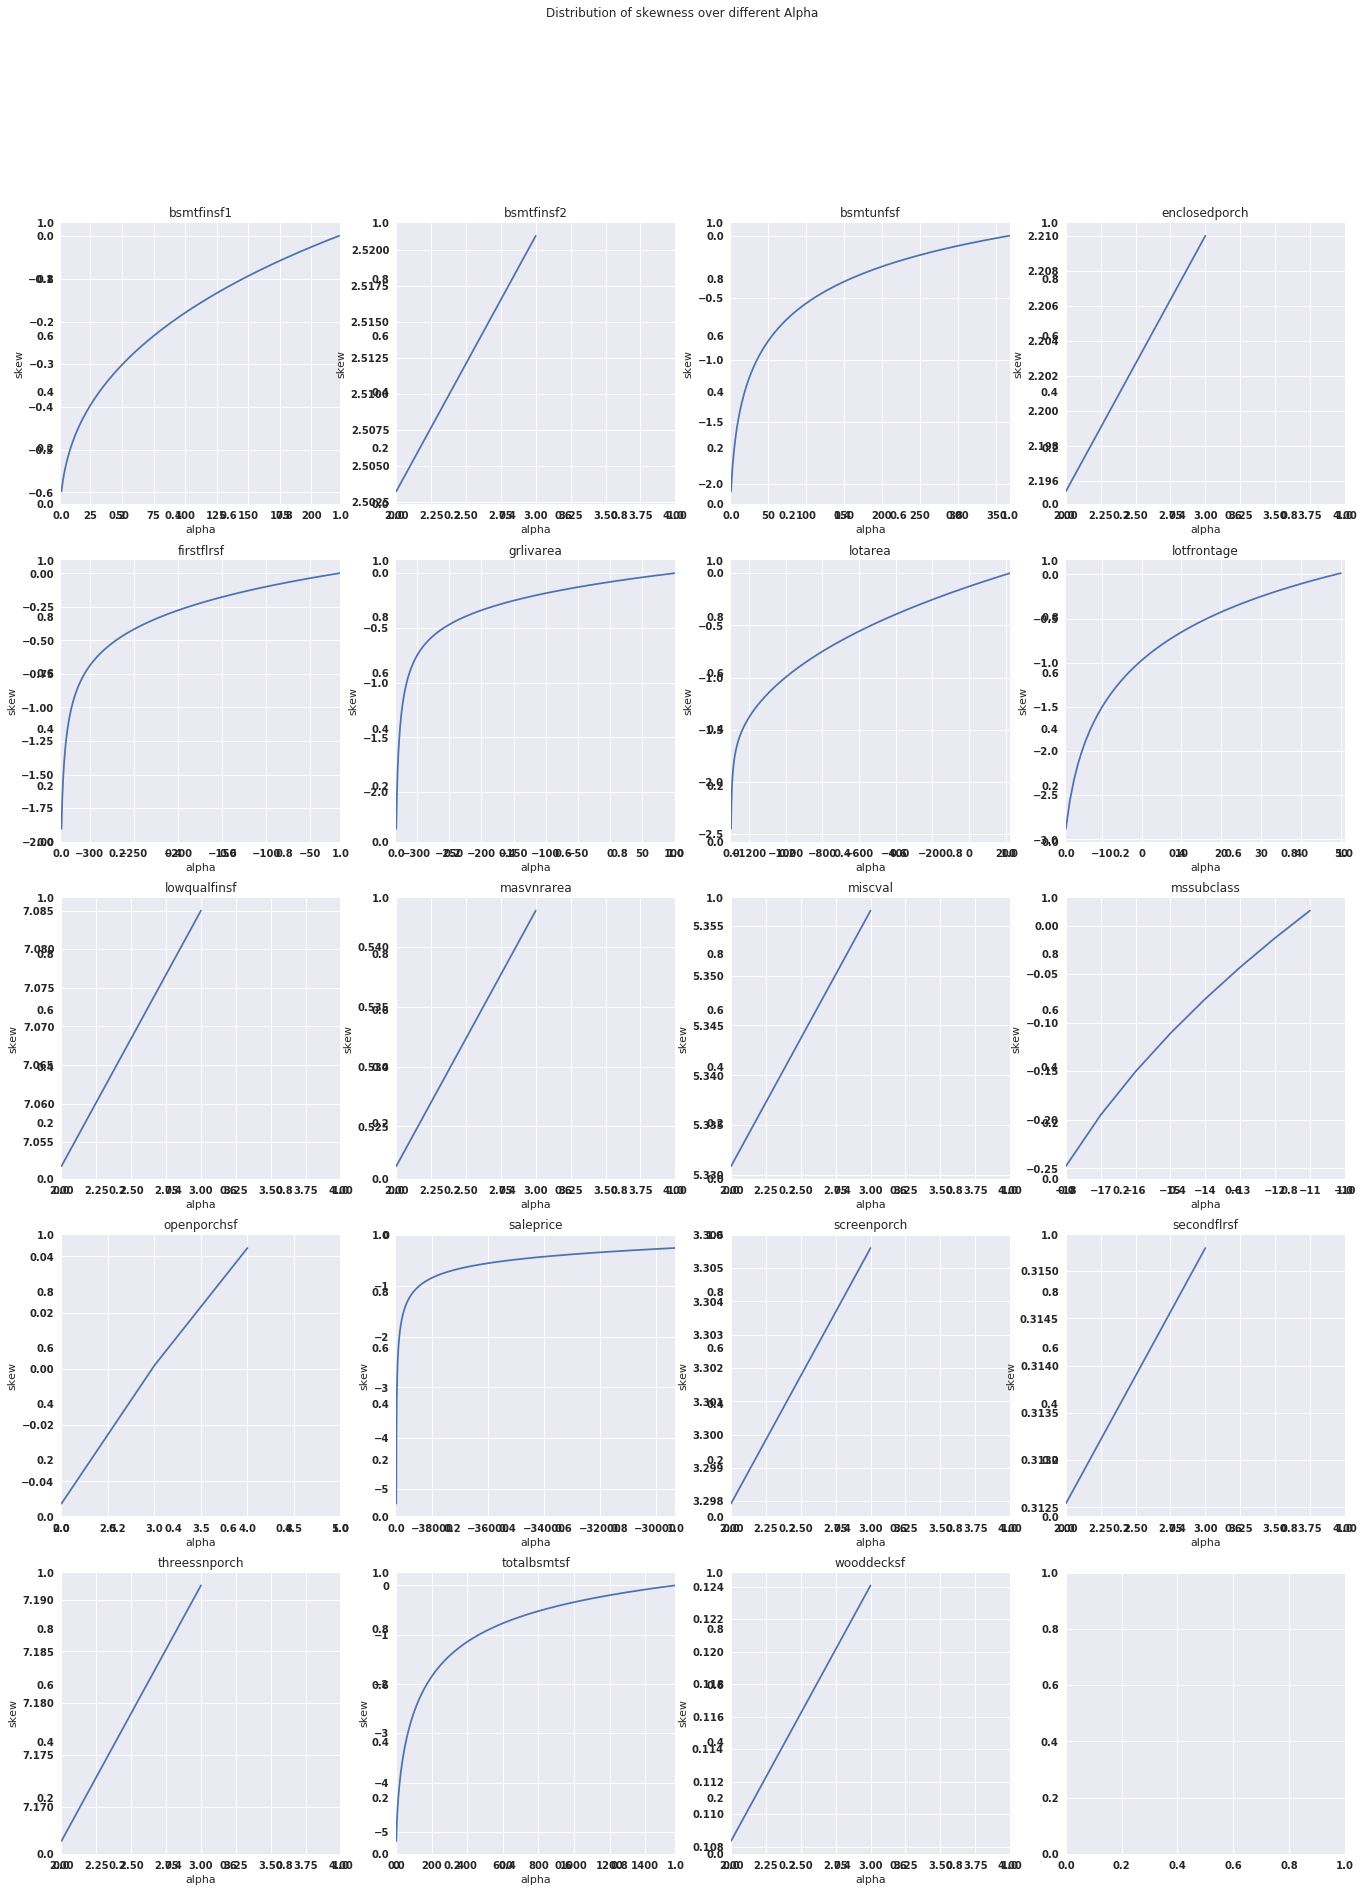

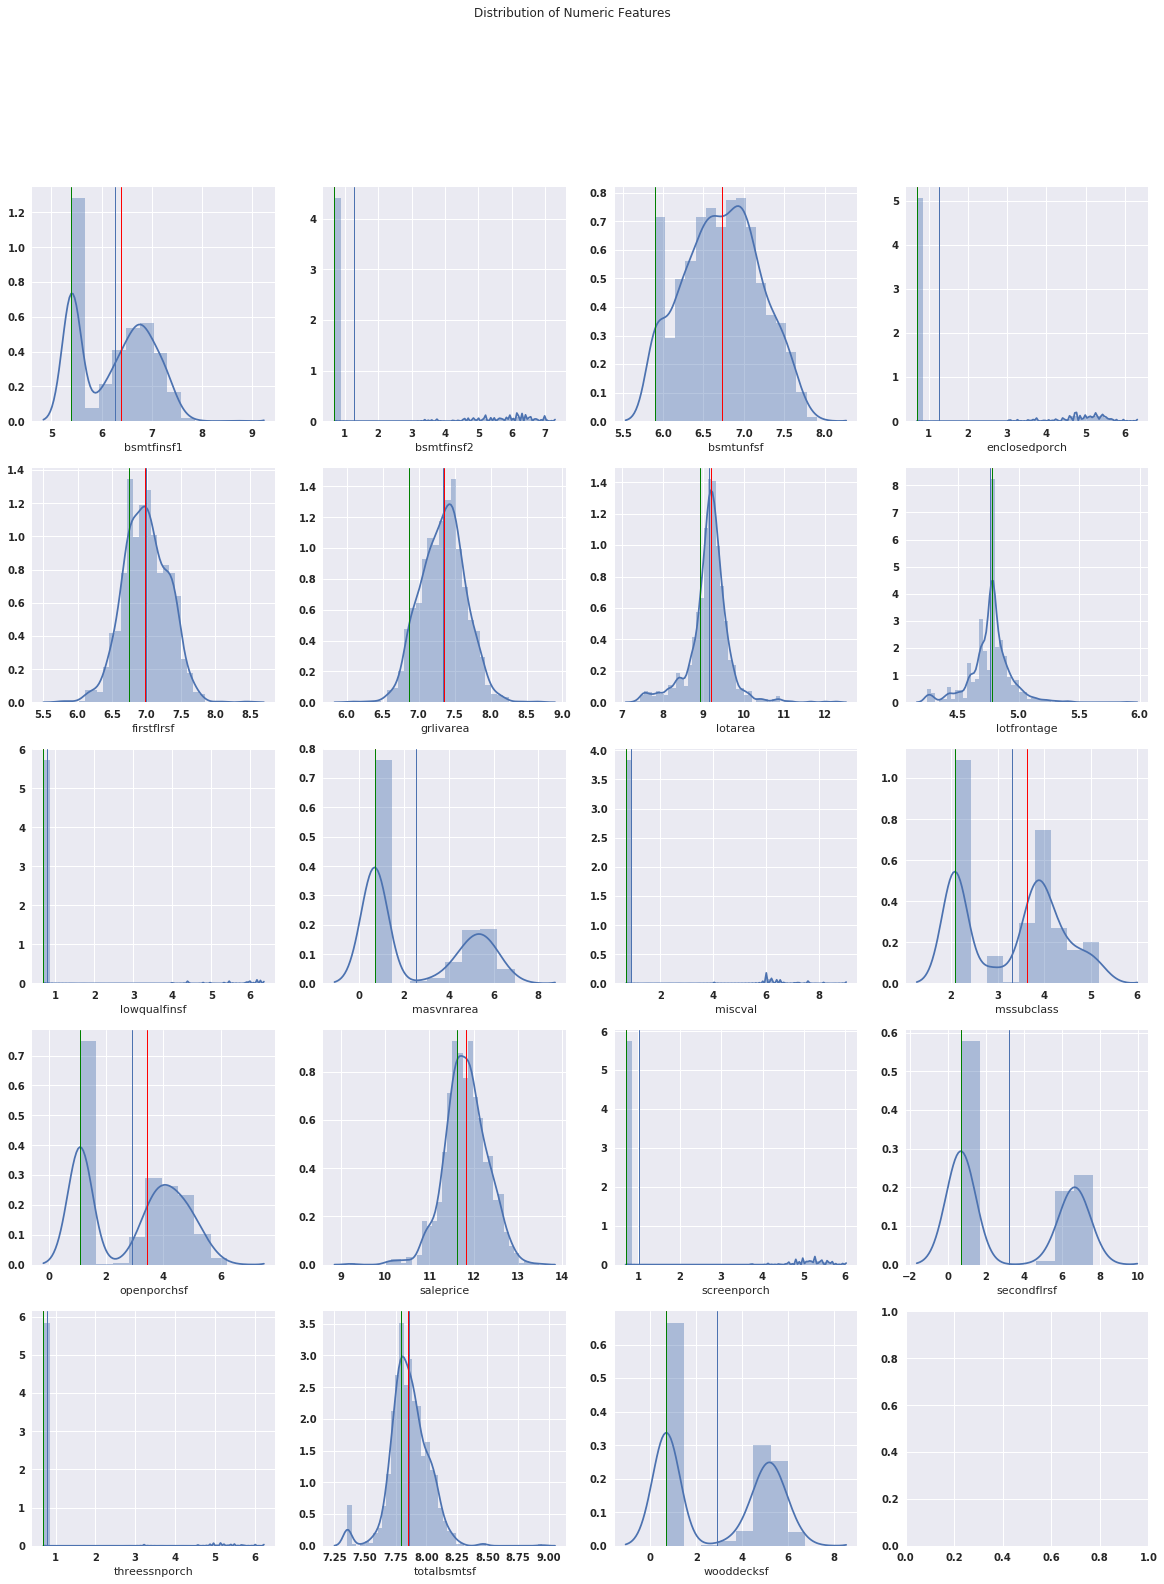

In [26]:
deskew_plot(houseprice_df)

### Use either a simple log or an optimal log to deskew the selected numerical features

### Use subplots to display distribution plots of all numerical features
Include the mean, median, and mode.

How do your distributions compare to the previous plots?

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


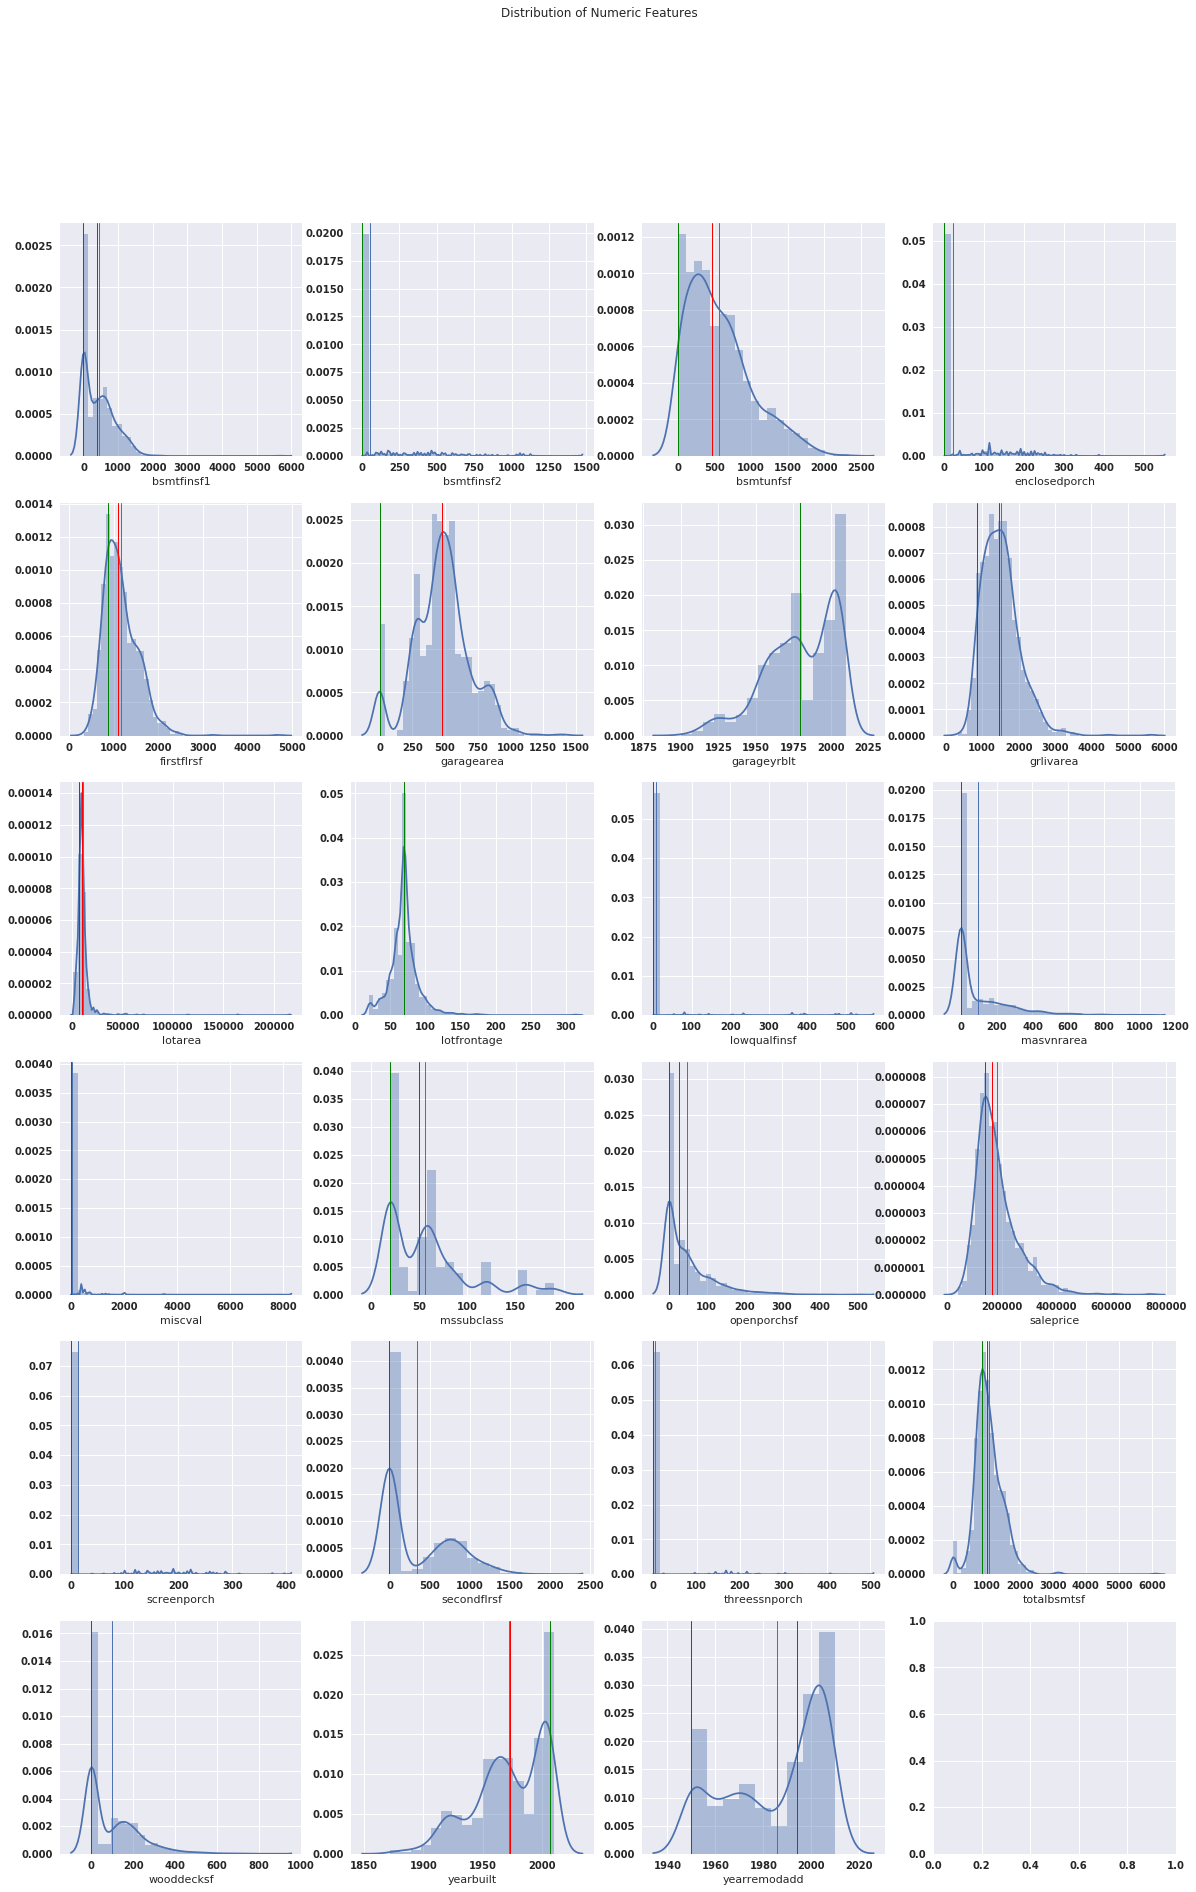

In [27]:
fig, axes = plt.subplots(6,4)
axes = axes.flatten()
fig.set_size_inches(20, 30)
fig.suptitle('Distribution of Numeric Features')
for i, col in enumerate(simple_deskewed_num_df.columns):
    feature = num_df[col]
    sns.distplot(feature, label=col, ax=axes[i])
    axes[i].axvline(feature.mean(),linewidth=1)
    axes[i].axvline(feature.median(),linewidth=1, color='r')
    axes[i].axvline(feature.mode().values[0],linewidth=1, color='g')

### Find the features with nans in the categorical dataframe

In [28]:
cat_nan_count={}
for col in cat_df.columns:
    if sum(cat_df[col].isnull())> 0: 
        cat_nan_count[col] = sum(cat_df[col].isnull())
   
print(cat_nan_count)    

{'bsmtfintype1': 25, 'bsmtqual': 25, 'garagecond': 63, 'garagetype': 63, 'garagequal': 63, 'electrical': 1, 'garagefinish': 63, 'masvnrtype': 6, 'bsmtfintype2': 26, 'bsmtexposure': 26, 'bsmtcond': 25}


### How many columns of each data type are there?

In [47]:
data_type={}
for col in cat_df.columns:
    key = cat_df[col].dtype
    if key in data_type:
        data_type[key] += 1
    else: 
        data_type[key] = 1
data_type 

{dtype('O'): 52}

### Replace the null rows for these features with the mode

In [30]:
cat_nan_count.keys()

dict_keys(['bsmtfintype1', 'bsmtqual', 'garagecond', 'garagetype', 'garagequal', 'electrical', 'garagefinish', 'masvnrtype', 'bsmtfintype2', 'bsmtexposure', 'bsmtcond'])

In [31]:
for col in cat_nan_count.keys():
    cat_df[col] = cat_df[col].where(cat_df[col].isnull()== False, cat_df[col].mode()[0])

In [32]:
for col in cat_df.columns:
    if any(cat_df[col].isnull()) == True:
        print(col)
print('no_null')        

no_null


### How many columns of each data type are there?

In [33]:
data_type={}
for col in cat_df.columns:
    key = cat_df[col].dtype
    if key in data_type:
        data_type[key] += 1
    else: 
        data_type[key] = 1
data_type 

{dtype('O'): 52}

In [34]:
cat_df.dtypes.value_counts()

object    52
dtype: int64

### Cast the whole categorical dataframe as an object

In [35]:
for col in cat_df.columns:
    cat_df[col] = cat_df[col].astype('object')
    

### Get Dummy Variable Columns for all categorical columns

In [36]:
cat_df_dummies = pd.get_dummies(cat_df)

### What is the shape of the new categorical dataframe?

In [37]:
cat_df_dummies.shape

(1095, 318)

In [38]:
cat_df_dummies.head()

,bedroomabvgr_0,bedroomabvgr_1,bedroomabvgr_2,bedroomabvgr_3,bedroomabvgr_4,bedroomabvgr_5,bedroomabvgr_6,bldgtype_1Fam,bldgtype_2fmCon,bldgtype_Duplex,...,totrmsabvgrd_10,totrmsabvgrd_11,totrmsabvgrd_12,utilities_AllPub,utilities_NoSeWa,yrsold_2006,yrsold_2007,yrsold_2008,yrsold_2009,yrsold_2010
id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,1,0,0,0,1,0,0,...,0,0,0,1,0,0,0,1,0,0
4,0,0,0,1,0,0,0,1,0,0,...,0,0,0,1,0,1,0,0,0,0
5,0,0,0,0,1,0,0,1,0,0,...,0,0,0,1,0,0,0,1,0,0
7,0,0,0,1,0,0,0,1,0,0,...,0,0,0,1,0,0,1,0,0,0
8,0,0,0,1,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0


### Merge the processed numerical and categorical dataframes

In [39]:
simple_deskewed_num_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1095 entries, 1 to 1460
Data columns (total 23 columns):
bsmtfinsf1       1095 non-null float64
bsmtfinsf2       1095 non-null float64
bsmtunfsf        1095 non-null float64
enclosedporch    1095 non-null float64
firstflrsf       1095 non-null float64
garagearea       1095 non-null float64
garageyrblt      1095 non-null float64
grlivarea        1095 non-null float64
lotarea          1095 non-null float64
lotfrontage      1095 non-null float64
lowqualfinsf     1095 non-null float64
masvnrarea       1095 non-null float64
miscval          1095 non-null float64
mssubclass       1095 non-null float64
openporchsf      1095 non-null float64
saleprice        1095 non-null float64
screenporch      1095 non-null float64
secondflrsf      1095 non-null float64
threessnporch    1095 non-null float64
totalbsmtsf      1095 non-null float64
wooddecksf       1095 non-null float64
yearbuilt        1095 non-null float64
yearremodadd     1095 non-null floa

In [40]:
deskewed_df.head()

,bsmtfinsf1,bsmtfinsf2,bsmtunfsf,enclosedporch,firstflrsf,grlivarea,lotarea,lotfrontage,lowqualfinsf,masvnrarea,...,saleprice,screenporch,secondflrsf,threessnporch,totalbsmtsf,wooddecksf,garagearea,garageyrblt,yearbuilt,yearremodadd
id,,,,,,,,,,,,,,,,,,,,,
1,6.8320,0.6931,6.2461,0.6931,6.7310,7.5005,9.0677,4.7362,0.6931,5.2883,...,12.0963,0.6931,6.7523,0.6931,7.7928,0.6931,548.0,2003.0,2003.0,2003.0
4,6.0799,0.6931,6.8090,5.6131,6.8491,7.5044,9.1872,4.6913,0.6931,0.6931,...,11.6146,0.6931,6.6307,0.6931,7.7506,0.6931,642.0,1998.0,1915.0,1970.0
5,6.7754,0.6931,6.7523,0.6931,7.0273,7.7394,9.5806,4.8903,0.6931,5.8636,...,12.3046,0.6931,6.9613,0.6931,7.9054,5.2679,836.0,2000.0,2000.0,2000.0
7,7.3715,0.6931,6.5265,0.6931,7.4242,7.4916,9.2404,4.8203,0.6931,5.2364,...,12.5343,0.6931,0.6931,0.6931,8.0873,5.5491,636.0,2004.0,2004.0,2005.0
8,6.9847,3.5264,6.3665,5.4381,6.9930,7.6912,9.2689,4.7822,0.6931,5.4889,...,12.0477,0.6931,6.8926,0.6931,7.8913,5.4681,484.0,1973.0,1973.0,1973.0


In [41]:
houseprice_df_cleaned_deskewed = simple_deskewed_num_df.merge(cat_df_dummies, left_index=True, right_index=True)
houseprice_df_cleaned_deskewed_alpha = deskewed_df.merge(cat_df_dummies, left_index=True, right_index=True)
houseprice_df_cleaned = num_df.merge(cat_df_dummies, left_index=True, right_index=True)

there is a reason to deskew dummies then scale for lasso

In [42]:
abs(skew(deskewed_df)) < abs(skew(simple_deskewed_num_df))

array([ True, False,  True, False,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True, False, False, False,  True,
        True,  True, False, False, False], dtype=bool)

### Assign `saleprice` to target and the remaining columns to `features`

In [43]:
target_deskewed = houseprice_df_cleaned_deskewed['saleprice']
features_deskewed =  houseprice_df_cleaned_deskewed.drop('saleprice', axis = 1)
features_deskewed.shape

(1095, 340)

In [44]:
target = houseprice_df_cleaned['saleprice']
features =  houseprice_df_cleaned.drop('saleprice', axis = 1)
features.shape

(1095, 340)

In [53]:
target_deskewed_scaled_w_Alpha = houseprice_df_cleaned_deskewed_alpha['saleprice']
features_deskewed_scaled_w_Alpha =  houseprice_df_cleaned_deskewed_alpha.drop('saleprice', axis = 1)
display(features_deskewed_scaled_w_Alpha.shape)

pickled_features_deskewed_scaled_w_Alpha = pd.DataFrame.to_pickle(features_deskewed_scaled_w_Alpha,'../pickled/pickled_features_deskewed_scaled_w_Alpha')
pickled_target_deskewed_scaled_w_Alpha = pd.DataFrame.to_pickle(target_deskewed_scaled_w_Alpha,'../pickled/pickled_target_deskewed_scaled_w_Alpha')

(1095, 340)

### pickle features and target dataframes

In [50]:
##turn it into a binary and save into a pickle
pickled_features_deskewed = pd.DataFrame.to_pickle(features_deskewed,'../pickled/pickled_features_deskewed')
pickled_target_deskewed = pd.DataFrame.to_pickle(target_deskewed,'../pickled/pickled_target_deskewed')
pickled_features = pd.DataFrame.to_pickle(features,'../pickled/pickled_features')
pickled_target = pd.DataFrame.to_pickle(target,'../pickled/pickled_target')


In [51]:
def generate_meta_info_df(df):
    feature_info = []
    for col in df.columns:
        info = { 
            'feature': col,
            'n_unique': len(set(df[col])),
            'datatype': df[col].dtype
        
        }
        feature_info.append(info)
    feature_info_df = pd.DataFrame(feature_info)  
    return feature_info_df
        

In [52]:
generate_meta_info_df(houseprice_df_cleaned)

,datatype,feature,n_unique
0,float64,bsmtfinsf1,525
1,float64,bsmtfinsf2,113
2,float64,bsmtunfsf,645
3,float64,enclosedporch,101
4,float64,firstflrsf,655
5,float64,garagearea,390
6,float64,garageyrblt,98
7,float64,grlivarea,719
8,float64,lotarea,838
9,float64,lotfrontage,108
